<a href="https://colab.research.google.com/github/goya5858/OSERO/blob/main/A2C_cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import torch.multiprocessing as mp
import time

import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gym
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import functional as F
import copy

# Agent

In [2]:
class Agent_Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1  = nn.Linear(4, 32)
        self.act1 = nn.ReLU()

        self.fc2  = nn.Linear(32, 32)
        self.act2 = nn.ReLU()

        self.pi_net = nn.Linear(32, 2)
        self.pi_act = nn.Softmax()

        self.V_net = nn.Linear(32,1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)

        x = self.fc2(x)
        x = self.act2(x)

        pi = self.pi_net(x)
        pi = self.pi_act(pi)

        V = self.V_net(x)
        return pi, V
    
    def get_weights(self):
        return {k: v.cpu() for k, v in self.state_dict().items()}

    def set_weights(self, weights):
        self.load_state_dict(weights)

    def get_gradients(self):
        grads = []
        for p in self.parameters():
            grad = None if p.grad is None else p.grad.data.cpu().numpy()
            grads.append(grad)
        return grads

    def set_gradients(self, gradients):
        for g, p in zip(gradients, self.parameters()):
            if g is not None:
                p.grad = torch.from_numpy(g)

In [3]:
from collections import namedtuple
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'pi_prob', 'v_value'))

class Agent_Memory():
    def __init__(self):
        self.capacity = ADVANTAGE #Advantageを計算するために、Xstep分の履歴を保存する
        self.memory = []
        self.index = 0
    
    def put_memory(self, state, action, reward, pi_prob, v_value):
        '''transition = (self, state, action, reward, pi_prob, v_value)をメモリに保存する'''
        if len(self.memory) < self.capacity:
            self.memory.append(None)  # メモリが満タンでないときは足す
        self.memory[self.index] = Transition(state, action, reward, pi_prob, v_value)
        self.index = (self.index + 1) % self.capacity  # 保存するindexを1つずらす

    def get_Advantage(self, Last_V):
        transitions = self.memory
        #State, Action, Reward, State_Nextの各要素ごとにまとめ直しTensorに変換する
        BATCH = Transition(*zip(*transitions)) 
        State_BATCH   = torch.tensor( np.stack( BATCH.state ) ,dtype=torch.float)
        Action_BATCH  = torch.tensor( np.stack( BATCH.action ) ,dtype=torch.int64)
        Reward_BATCH  = torch.tensor( np.stack( BATCH.reward ) ,dtype=torch.float)
        Pi_prob_BATCH = torch.stack( BATCH.pi_prob )
        V_value_BATCH = torch.stack( BATCH.v_value )

        # Nstep分の割引報酬を計算し、Advantageを計算する
        Returns        = torch.zeros([Reward_BATCH.shape[0]+1]) 
        Returns[-1]  = Last_V
        for i in reversed(range(len(Reward_BATCH))):
            Returns[i] = Reward_BATCH[i]+GAMMA*Returns[i+1]
        Returns   = Returns[:-1].reshape(1,-1)
        Advantage = Returns.detach() - V_value_BATCH
        return Advantage.reshape(-1), Pi_prob_BATCH

In [4]:
# Master-Agent
# Worker-Agentが入手した勾配をまとめて同期的に受け取って、自身の重みを更新し、WorkerAgentに渡す
class MasterAgent():
    def __init__(self):
        self.Network = Agent_Network()
        self.optim   = optim.Adam(self.Network.parameters(), lr=LR)
        self.scheduler = optim.lr_scheduler.StepLR(optimizer=self.optim, step_size=LR_STEP, gamma=LR_GAMMA)
    
    def apply_gradients(self, *gradients):
        summed_gradients = [
            np.stack(gradient_zip).mean(axis=0) for gradient_zip in zip(*gradients)
        ]
        summed_gradients = summed_gradients[0]
        self.optim.zero_grad()
        self.Network.set_gradients(summed_gradients)
        nn.utils.clip_grad_norm_(self.Network.parameters(), CLIP)
        self.optim.step()
        self.scheduler.step()
        return self.Network.get_weights()

    def get_weights(self):
        return self.Network.get_weights()

In [5]:
# 実際にタスクをこなして、勾配を計算して出力する
# Masterより受け取った重みを自身に適用する
class WorkerAgent():
    def __init__(self):
        self.Network = Agent_Network()
        self.Memory  = Agent_Memory()
    
    def set_weights(self, weights):
        self.Network.set_weights(weights)

    def get_action(self, state, episode): 
        # ε-greedy法で徐々に最適行動のみを採用する
        #self.Network.eval()  # ネットワークを推論モードに切り替える
        pi_values, V_value = self.Network( torch.tensor( state, dtype=torch.float ) )
        m = Categorical(pi_values)

        epsilon = 0.5 * (1 / (episode + 1))
        if epsilon <= np.random.uniform(0, 1):
            action = m.sample()
        else:
            action = np.random.choice(2)   # 0,1の行動をランダムに返す
            action = torch.tensor( action )
        #log_prob = -1 * m.log_prob(action)
        pi_prob = m.probs[ action.to(torch.long) ]
        return action, pi_prob, V_value[0]

    def compute_gradients(self, Last_V):
        # Memoryから学習用のデータを取り出す
        Advantage, Pi_prob_BATCH = self.Memory.get_Advantage(Last_V)

        V_loss  = Advantage.pow(2).mean() #２乗平均をとる
        Log_prob_BATCH = torch.log( Pi_prob_BATCH )
        pi_gain = ( Log_prob_BATCH * Advantage.detach() ).mean()
        entropy  = -1*( Pi_prob_BATCH * Log_prob_BATCH ).mean()

        loss = 0.5*V_loss - pi_gain #- 0.01*entropy
        loss.backward()
        
        self.Memory.memory = []
        self.Memory.index = 0
        return self.Network.get_gradients()
    
    def memorize(self, state, action, reward, pi_prob, v_value):
        self.Memory.put_memory(state, action, reward, pi_prob, v_value)

# Task

In [6]:
#Task_model = gym.make('CartPole-v0')

# Worker-Task-Env

In [7]:
# Advantage_Step分タスクを行い、その都度計算された勾配を返す環境
# WorkerAgentとTaskをそれぞれ保持している

class Work_on_Task:
    def __init__(self):
        self.Worker = WorkerAgent()
        self.Task   = gym.make('CartPole-v0')
        self.T      = 0 #経過時間
        self.done   = False
        self.state  = self.Task.reset()
    
    def step_Advantage(self, state, current_weights, episode):
        # Advantage_Step分、タスクを進めて　State, Action, Rewordを記録する
        self.Worker.set_weights(current_weights) # 最初にMasterからWorkerに重みをコピーする
        for advantage_step in range(ADVANTAGE): #Advantage分のStepsを1サイクルと考える    
            action, pi_prob, v_value       = self.Worker.get_action(state, episode)
            state_next, reword, done, info = self.Task.step(action.item()) #Action_tを場面に渡してState_t+1, Reword_tを受け取る

            if done: #倒れていたor終了した場合
                next_state = None
                if self.T < 195: #195ステップ以内なら失敗
                    reword = -1
                else: #195ステップ以上たってたら成功
                    reword = 1
            else: #各ステップで立ってたら報酬追加
                reword = 0

            # 結果の記録
            self.Worker.memorize(state, action, reword, pi_prob, v_value)
            state = state_next
            self.T += 1
            
            if done:# Advantageの途中で終わってたら抜ける
                break 
        return state, done, self.T
    
    def compute_gradients(self, state, episode):
        # Advantage_Step分の行動の記録から勾配を計算する
        if state is not None:
            _, _, Last_V  = self.Worker.get_action(state, episode)
        else:
            Last_V = torch.tensor(0)
        gradients = [self.Worker.compute_gradients(Last_V)]
        return gradients
    
    def steps_and_grad(self, current_weights, episode):
        # 上記の２つのメソッドを同時にこなす
        if not self.done:
            state = self.state
            state, done, t = self.step_Advantage(state, current_weights, episode)
            gradients      = self.compute_gradients(state, episode)
            self.state = state
            self.done   = done
        else:
            gradients = None
        return gradients, self.done, self.T
    
    def reset(self):
        self.state  = self.Task.reset()
        self.T = 0
        self.done   = False

# Training Environment

In [10]:
class Environment():
    def __init__(self):
        self.Master        = MasterAgent()
        self.Work_on_Tasks = [ Work_on_Task() for _ in range(NUM_PROCESS) ]
    
    def run_one_episode(self, episode):
        # 倒れるか、200秒持ち堪え耐えるまでが１エピソード
        # 各episodeの最初にTaskをリセット        
        [worker.reset() for worker in self.Work_on_Tasks]
        current_weights = self.Master.get_weights()
        while True:
            # Advantage_step分進めるのをひとまとまりとする
            gradients, done, ts = zip(*[ worker.steps_and_grad(current_weights, episode) for worker in self.Work_on_Tasks ])
            gradients = [grad for grad in gradients if grad is not None]
            current_weights    = self.Master.apply_gradients(*gradients)
            done = True if sum(done)==NUM_PROCESS else False
            t = np.mean(ts)
            if done: #全体のループを抜ける 
                [worker.reset() for worker in self.Work_on_Tasks]
                break    
        return t, ts
    
    def train(self):
        TIMES = []
        times = 0
        episode = 0
        while True:
            times, Times = self.run_one_episode(episode)
            print('episode :', episode)
            print("mean_time :", times)
            print("times :", Times)
            print('='*10, "\n")
            episode += 1
            TIMES.append(times)

            if ( (len(TIMES) > 10) & (np.mean(TIMES[-10:]) >= 150) ) or (len(TIMES) > MAX_ITER):
                break
        return TIMES

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


episode : 0
mean_time : 16.875
times : (17, 14, 9, 23, 29, 13, 18, 12)

episode : 1
mean_time : 25.625
times : (44, 14, 17, 38, 33, 9, 14, 36)

episode : 2
mean_time : 22.75
times : (25, 13, 15, 21, 34, 17, 17, 40)

episode : 3
mean_time : 22.5
times : (21, 23, 13, 28, 10, 19, 53, 13)

episode : 4
mean_time : 26.875
times : (23, 22, 53, 31, 19, 29, 29, 9)

episode : 5
mean_time : 30.0
times : (17, 21, 13, 14, 40, 55, 44, 36)

episode : 6
mean_time : 31.5
times : (58, 48, 20, 15, 11, 62, 29, 9)

episode : 7
mean_time : 16.75
times : (14, 15, 15, 17, 22, 17, 13, 21)

episode : 8
mean_time : 20.625
times : (10, 23, 49, 16, 13, 12, 17, 25)

episode : 9
mean_time : 23.375
times : (28, 24, 21, 26, 11, 10, 30, 37)

episode : 10
mean_time : 26.0
times : (16, 16, 13, 11, 71, 24, 22, 35)

episode : 11
mean_time : 22.125
times : (14, 22, 15, 26, 17, 32, 17, 34)

episode : 12
mean_time : 17.375
times : (20, 13, 20, 18, 9, 12, 23, 24)

episode : 13
mean_time : 26.375
times : (25, 21, 29, 14, 32, 25

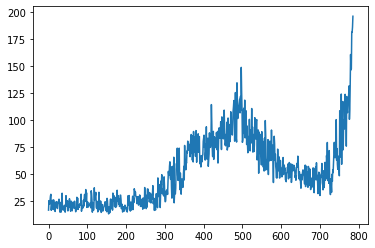

In [13]:
NUM_PROCESS = 8
ADVANTAGE = 5

MAX_ITER = 1000
GAMMA = 0.99
CLIP = 0.005
LR = 0.0005 / NUM_PROCESS

LR_STEP  = 100
LR_GAMMA = 1

AAA = Environment()
TTT = AAA.train()

X = range(len(TTT))
plt.plot(X, TTT)